### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")

sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation

import jax.numpy as jnp
import numpyro

N = 2
K = 20
C = 20
seed = 3
sigma_m = 10.
sigma_c = 10.


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


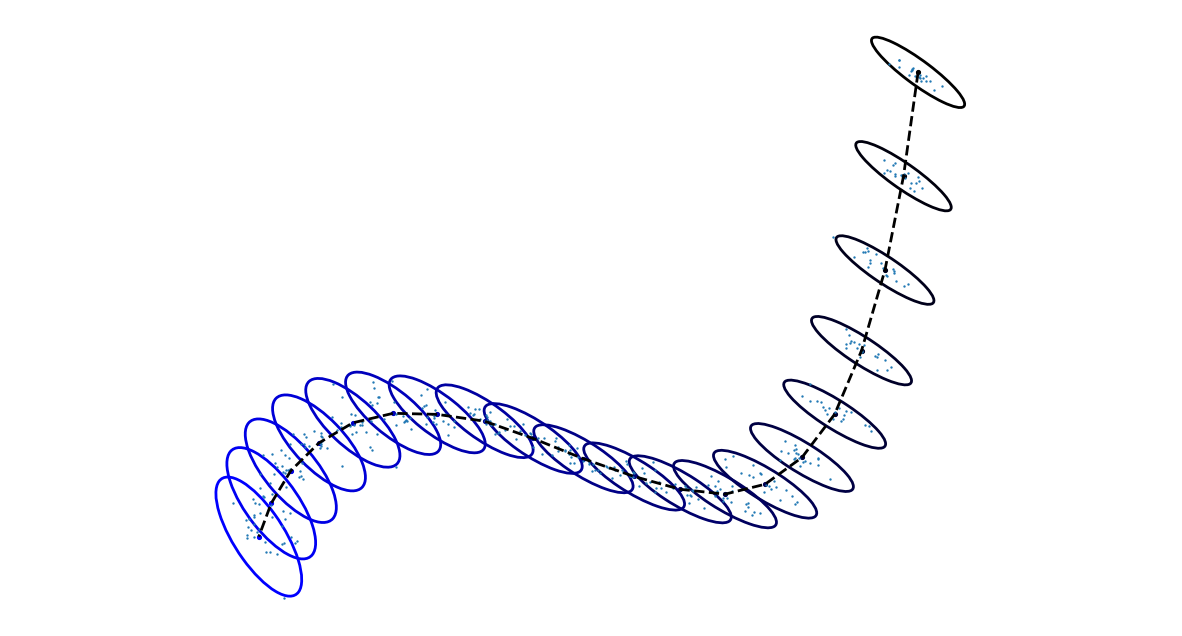

In [2]:
# Make fake dataset
rng = [-10,10] # range of input conditions
x = jnp.linspace(rng[0], rng[1], C)

# Kernel functions
kernel_gp = lambda x, y: 1e1*(1e-6*(x==y)+jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma_m**2)))
kernel_wp = lambda x, y: 1e-6*(x==y)+jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma_c**2))

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=kernel_gp,N=N)
wp = models.WishartProcess(kernel=kernel_wp,P=N+1,V=1e-2*jnp.eye(N), optimize_L=False)

# Likelihood model
likelihood = models.NormalConditionalLikelihood(N)

# Sample from the generative model and create synthetic dataset
with numpyro.handlers.seed(rng_seed=seed):
    mu = gp.sample(x)
    sigma = wp.sample(x)
    data = [likelihood.sample(mu,sigma,ind=jnp.arange(len(mu))) for i in range(K)]
    y = jnp.stack(data)

visualizations.visualize_pc(
    mu[:,None],sigma,pc=y.reshape(y.shape[0]*y.shape[1],-1)
)

Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [3]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)
varfam.infer(adam,x,y,n_iter = 2000,key=key)
joint.update_params(varfam.posterior)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/2000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 2000/2000 [00:06<00:00, 313.12it/s, init loss: 59472930.8383, avg. loss [1901-2000]: 1731.3298]


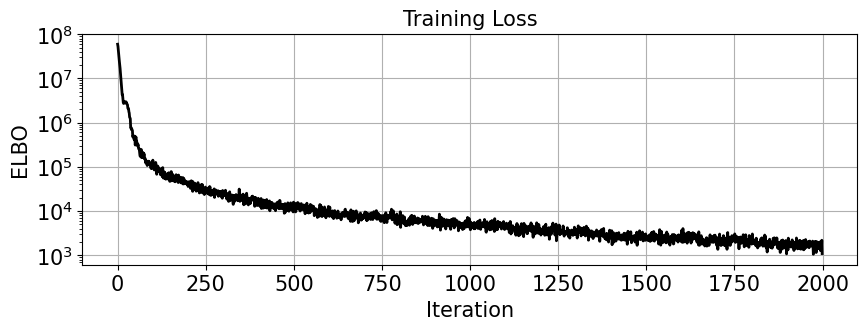

In [4]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

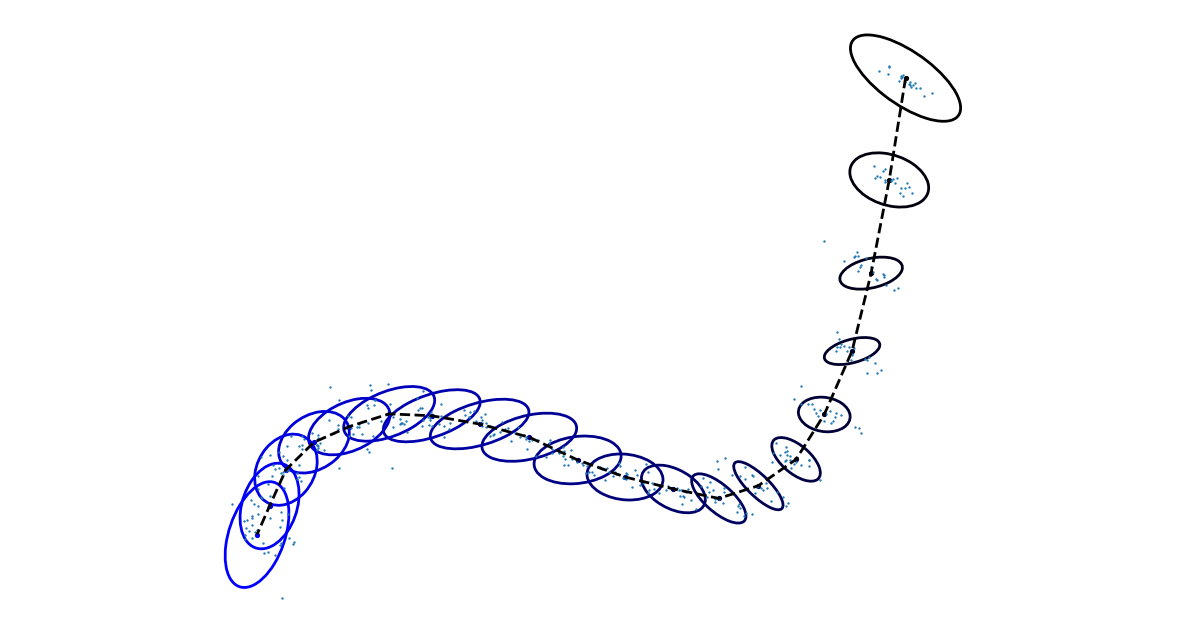

In [5]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(x)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=y.reshape(y.shape[0]*y.shape[1],-1)
)


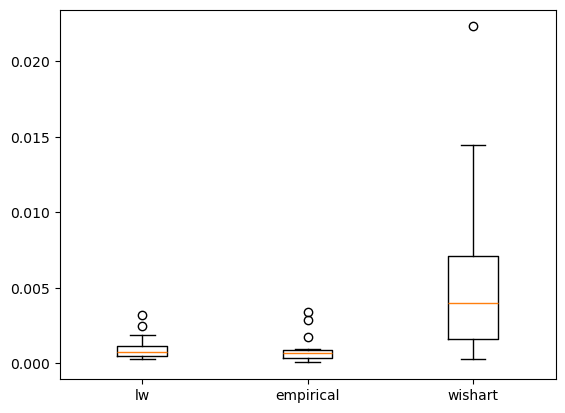

In [6]:
# %% Evaluation and comparison with other methods
compared = evaluation.compare(y)
compared['wishart'] = sigma_hat.transpose(1,2,0)
performance = evaluation.evaluate(compared,sigma.transpose(1,2,0))

visualizations.plot_box(performance)

In [7]:
# Evaluate posterior mode
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)

# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=seed):
    mu_prime, sigma_prime = posterior.derivative(x)

# For the Poisson model, compute summary statistics (such as mean firing rate)
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat = posterior.mean_stat(lambda x: x, x)

KeyboardInterrupt: 

Since we use GP and WP as underlying models it's very easy to sample means and covariances in unseen test conditions:

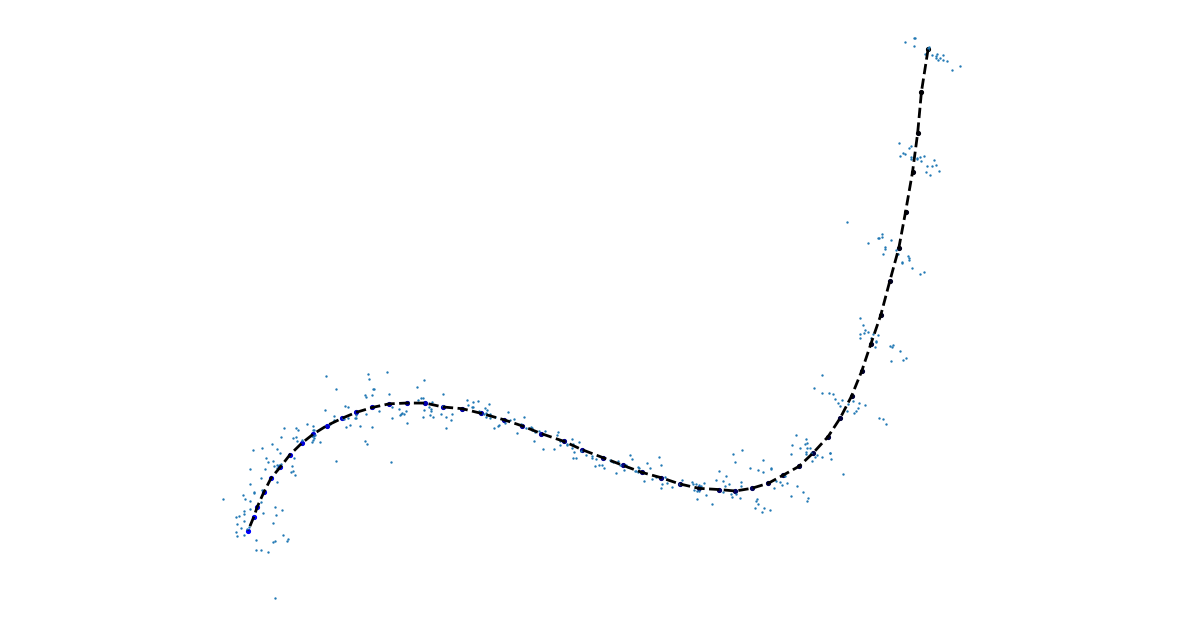

(50, 2)


In [6]:
# Given
# -----
# X_test : ndarray, (num_test_conditions x num_variables), test data from first network.

# Interpolate covariances in unseen test conditions 
x_test = jnp.linspace(rng[0], rng[1], 50)
with numpyro.handlers.seed(rng_seed=seed):
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(x_test)

visualizations.visualize_pc(
    mu_test_hat[:,None],sigma_test_hat,pc=y.reshape(y.shape[0]*y.shape[1],-1)
)

print(mu_test_hat.shape)